## 6. End-to-End Pipeline

### `06_pipeline_integration.ipynb`

Successfully loaded models and preprocessing objects
Processing ..\data\videos\fall_1.mp4...

0: 384x640 2 persons, 50.0ms
Speed: 2.4ms preprocess, 50.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 49.2ms
Speed: 2.4ms preprocess, 49.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 52.5ms
Speed: 2.0ms preprocess, 52.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 51.7ms
Speed: 2.8ms preprocess, 51.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 61.8ms
Speed: 2.4ms preprocess, 61.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 57.6ms
Speed: 3.1ms preprocess, 57.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 56.5ms
Speed: 3.0ms preprocess, 56.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person

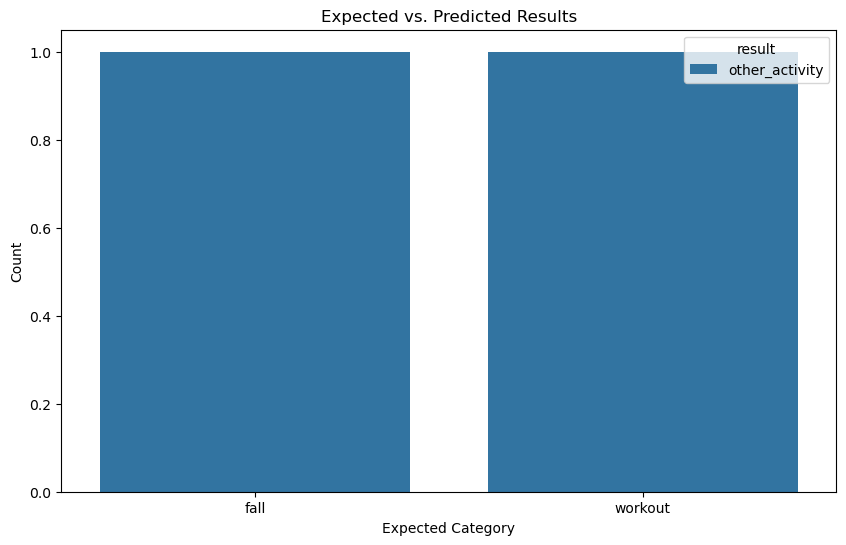


0: 384x640 2 persons, 42.2ms
Speed: 1.7ms preprocess, 42.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 43.5ms
Speed: 2.0ms preprocess, 43.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 42.3ms
Speed: 2.7ms preprocess, 42.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 41.2ms
Speed: 1.9ms preprocess, 41.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


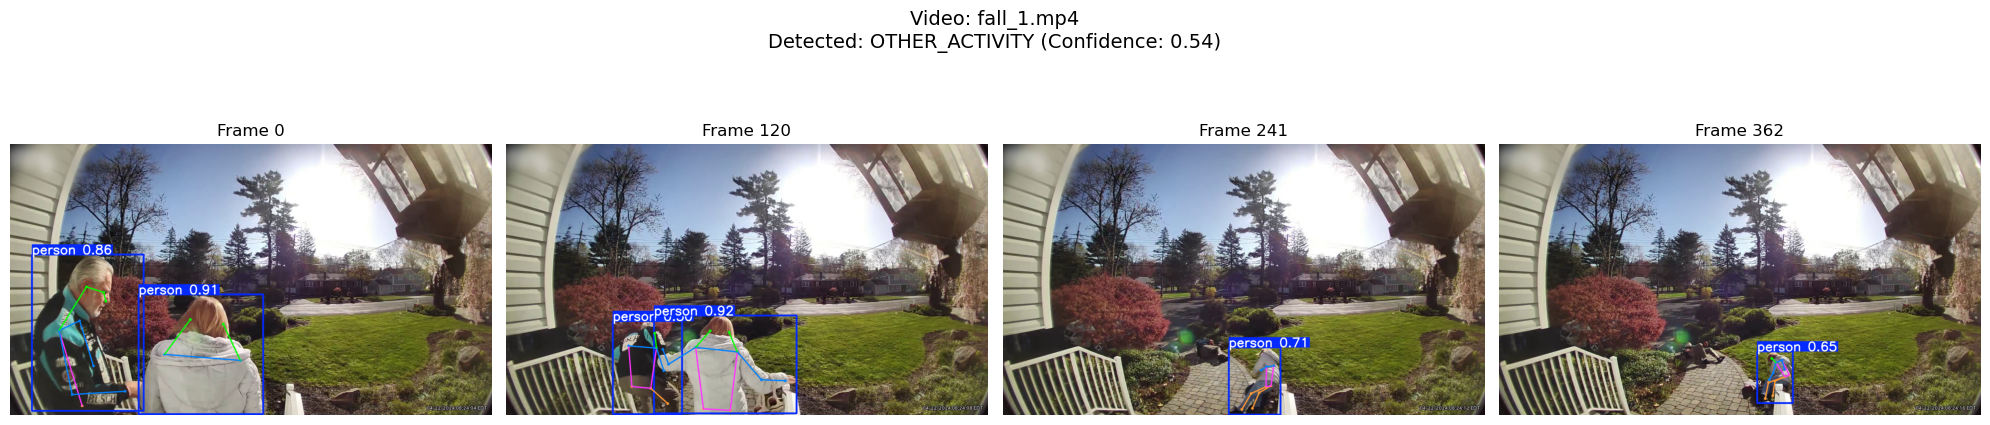


0: 384x640 1 person, 42.0ms
Speed: 1.5ms preprocess, 42.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 39.9ms
Speed: 2.2ms preprocess, 39.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 43.1ms
Speed: 1.5ms preprocess, 43.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 41.9ms
Speed: 1.8ms preprocess, 41.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


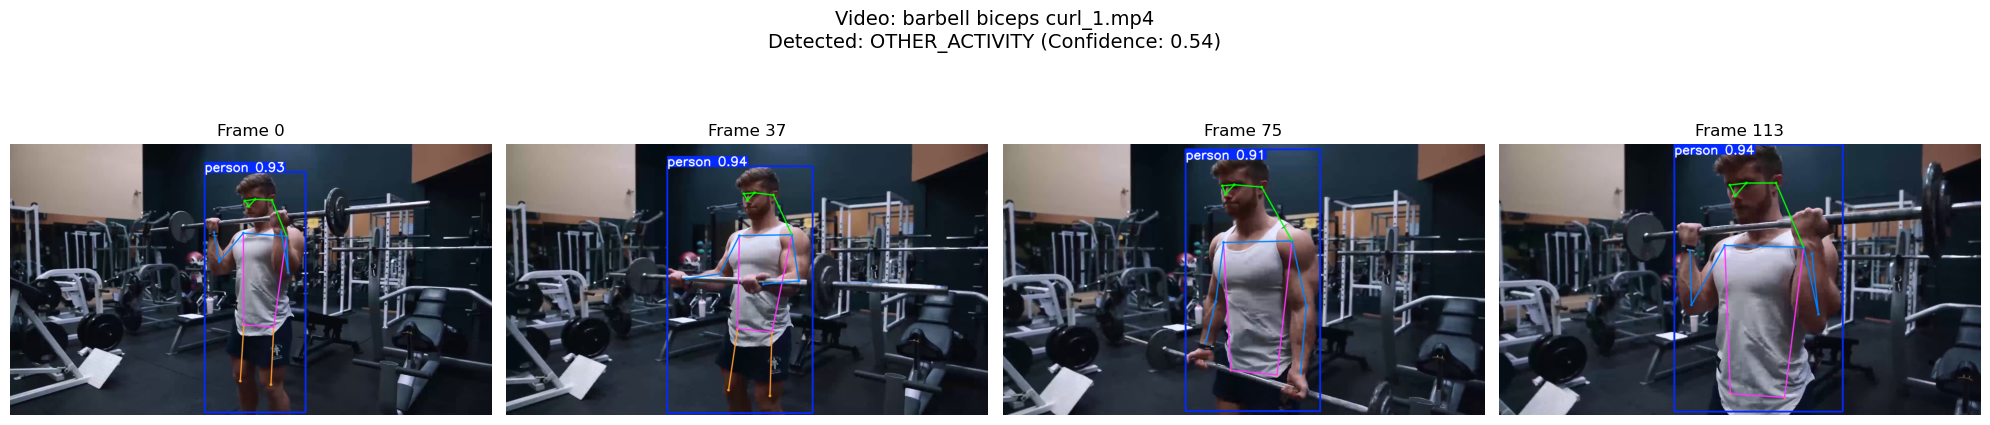

Detection system saved to ../outputs/pipeline_results\detection_system.pkl


In [26]:
# Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
from ultralytics import YOLO
from pathlib import Path
import joblib
import pickle
%matplotlib inline

# Set paths
MODELS_DIR = "../outputs/models"
DATA_DIR = "../data"
OUTPUT_DIR = "../outputs/pipeline_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load models and preprocessing objects
try:
    workout_model = load_model(os.path.join(MODELS_DIR, 'workout_classifier.h5'))
    fall_model = load_model(os.path.join(MODELS_DIR, 'fall_classifier.h5'))
    
    workout_scaler = joblib.load(os.path.join(MODELS_DIR, 'workout_scaler.pkl'))
    fall_scaler = joblib.load(os.path.join(MODELS_DIR, 'fall_scaler.pkl'))
    
    feature_cols = pd.read_csv(os.path.join(MODELS_DIR, 'feature_columns.txt')).iloc[:, 0].tolist()
    
    print("Successfully loaded models and preprocessing objects")
    
except Exception as e:
    print(f"Error loading models: {e}")
    print("Please run the model development notebook first")
    
    # For demonstration, create dummy models
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    
    workout_model = Sequential([
        Dense(10, activation='relu', input_shape=(11,)),
        Dense(1, activation='sigmoid')
    ])
    workout_model.compile(optimizer='adam', loss='binary_crossentropy')
    
    fall_model = Sequential([
        Dense(10, activation='relu', input_shape=(11,)),
        Dense(1, activation='sigmoid')
    ])
    fall_model.compile(optimizer='adam', loss='binary_crossentropy')
    
    from sklearn.preprocessing import StandardScaler
    workout_scaler = StandardScaler()
    fall_scaler = StandardScaler()
    
    feature_cols = [
        'max_velocity', 'mean_velocity', 'std_velocity',
        'max_height', 'min_height', 'height_range',
        'max_width', 'min_width', 'width_range',
        'head_y_change', 'max_head_y_change'
    ]

# Initialize YOLO models
person_model = YOLO('yolov8n.pt')      # For person detection
pose_model = YOLO('yolov8n-pose.pt')   # For pose estimation

# Two-stage detection system implementation
class FallWorkoutDetectionSystem:
    def __init__(self, workout_model, fall_model, workout_scaler, fall_scaler, feature_cols, pose_threshold=0.5):
        self.workout_model = workout_model
        self.fall_model = fall_model
        self.workout_scaler = workout_scaler
        self.fall_scaler = fall_scaler
        self.feature_cols = feature_cols
        self.pose_threshold = pose_threshold
        
        # Initialize YOLO models
        self.person_model = YOLO('yolov8n.pt')
        self.pose_model = YOLO('yolov8n-pose.pt')
    
    def process_video(self, video_path, output_visualization=False):
        """Process a video through the two-stage fall/workout detection system"""
        # Extract features using YOLOv8-pose
        keypoints, features = self.extract_features(video_path)
        
        if features is None:
            return {
                'result': 'no_features_extracted',
                'confidence': 0.0,
                'video_path': video_path
            }
        
        # Prepare features for model input
        X = np.array([[features.get(col, 0) for col in self.feature_cols]])
        
        # Stage 1: Check if it's a workout
        X_workout_scaled = self.workout_scaler.transform(X)
        workout_pred = self.workout_model.predict(X_workout_scaled, verbose=0)[0][0]
        is_workout = workout_pred > 0.5
        
        if is_workout:
            result = {
                'result': 'workout',
                'confidence': float(workout_pred),
                'video_path': video_path,
                'features': features
            }
        else:
            # Stage 2: If not workout, check for fall
            X_fall_scaled = self.fall_scaler.transform(X)
            fall_pred = self.fall_model.predict(X_fall_scaled, verbose=0)[0][0]
            is_fall = fall_pred > 0.5
            
            if is_fall:
                result = {
                    'result': 'fall',
                    'confidence': float(fall_pred),
                    'video_path': video_path,
                    'features': features
                }
            else:
                result = {
                    'result': 'other_activity',
                    'confidence': float(1.0 - fall_pred),
                    'video_path': video_path,
                    'features': features
                }
        
        # Create visualization if requested
        if output_visualization:
            self.create_visualization(video_path, result)
        
        return result
    
    def extract_features(self, video_path, num_frames=16):
        """Extract pose and motion features using YOLOv8-pose"""
        cap = cv2.VideoCapture(video_path)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        
        # Calculate frame indices to sample
        indices = np.linspace(0, frame_count-1, num_frames, dtype=int)
        
        # Store keypoint sequences
        keypoint_sequence = []
        is_pose_detected = []
        
        for idx in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            
            if not ret:
                keypoint_sequence.append(None)
                is_pose_detected.append(False)
                continue
            
            # Run YOLOv8-pose detection
            pose_results = self.pose_model(frame, conf=self.pose_threshold)
            
            if len(pose_results[0].keypoints.data) > 0:
                is_pose_detected.append(True)
                
                # Get the pose with highest confidence (usually the largest one)
                best_pose_idx = 0
                if len(pose_results[0].boxes) > 1:
                    # If multiple poses, get the one with highest confidence
                    confidences = [box.conf.item() for box in pose_results[0].boxes]
                    best_pose_idx = np.argmax(confidences)
                
                # Extract keypoints for the best pose
                pose_keypoints = pose_results[0].keypoints.data[best_pose_idx]
                
                # Convert to a flat list format similar to what we had with MediaPipe
                frame_keypoints = []
                for kp_idx in range(pose_keypoints.shape[0]):
                    x, y, conf = pose_keypoints[kp_idx].tolist()
                    # Normalize coordinates
                    frame_keypoints.extend([
                        float(x) / frame_width,
                        float(y) / frame_height,
                        0.0,  # YOLOv8 doesn't provide z-coordinate
                        float(conf)
                    ])
                
                keypoint_sequence.append(frame_keypoints)
            else:
                is_pose_detected.append(False)
                keypoint_sequence.append(None)
        
        cap.release()
        
        # If no poses detected, return None
        if not any(is_pose_detected):
            return None, None
        
        # Calculate pose-based features
        valid_keypoints = [kp for kp in keypoint_sequence if kp is not None]
        
        if not valid_keypoints:
            return None, None
        
        # Create features
        features = {}
        
        # 1. Keypoint velocities
        if len(valid_keypoints) >= 2:
            velocities = []
            for i in range(1, len(valid_keypoints)):
                frame_velocities = []
                for j in range(0, len(valid_keypoints[i]), 4):  # Each keypoint has 4 values (x,y,z,v)
                    if j+3 < len(valid_keypoints[i]) and j+3 < len(valid_keypoints[i-1]):
                        # Calculate Euclidean distance between consecutive frames
                        dx = valid_keypoints[i][j] - valid_keypoints[i-1][j]
                        dy = valid_keypoints[i][j+1] - valid_keypoints[i-1][j+1]
                        # Note: YOLOv8 doesn't have z-coordinate, so we use 0
                        velocity = np.sqrt(dx**2 + dy**2)
                        frame_velocities.append(velocity)
                
                if frame_velocities:
                    velocities.append(frame_velocities)
            
            if velocities:
                features['max_velocity'] = np.max([np.max(v) if v else 0 for v in velocities])
                features['mean_velocity'] = np.mean([np.mean(v) if v else 0 for v in velocities])
                features['std_velocity'] = np.std([np.std(v) if v else 0 for v in velocities])
        
        # 2. Pose height variation
        heights = []
        for kp in valid_keypoints:
            y_values = [kp[i+1] for i in range(0, len(kp), 4)]
            if y_values:
                height = max(y_values) - min(y_values)
                heights.append(height)
        
        if heights:
            features['max_height'] = np.max(heights)
            features['min_height'] = np.min(heights)
            features['height_range'] = np.max(heights) - np.min(heights)
        
        # 3. Pose width variation
        widths = []
        for kp in valid_keypoints:
            x_values = [kp[i] for i in range(0, len(kp), 4)]
            if x_values:
                width = max(x_values) - min(x_values)
                widths.append(width)
        
        if widths:
            features['max_width'] = np.max(widths)
            features['min_width'] = np.min(widths)
            features['width_range'] = np.max(widths) - np.min(widths)
        
        # 4. Vertical position change (for falls)
        # Note: In YOLOv8 pose, nose is keypoint index 0
        nose_positions = []
        for kp in valid_keypoints:
            if len(kp) >= 4:  # Nose is first landmark in YOLOv8-pose
                nose_positions.append(kp[1])  # y-coordinate of nose
        
        if nose_positions and len(nose_positions) >= 2:
            features['head_y_change'] = nose_positions[-1] - nose_positions[0]
            features['max_head_y_change'] = np.max(nose_positions) - np.min(nose_positions)
        
        # Return both raw keypoints and extracted features
        return valid_keypoints, features
    
    def create_visualization(self, video_path, result):
        """Create a visualization of the detection results with YOLOv8-pose"""
        # Output path for the visualization
        output_path = os.path.join(OUTPUT_DIR, 
                                  f"{os.path.basename(video_path).split('.')[0]}_detection.mp4")
        
        # Read the video
        cap = cv2.VideoCapture(video_path)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        
        # Create VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
        
        # Set up video processing
        frame_count = 0
        result_text = f"Result: {result['result'].upper()}"
        confidence_text = f"Confidence: {result['confidence']:.2f}"
        
        # Set text color based on result
        if result['result'] == 'workout':
            color = (0, 255, 0)  # Green for workout
        elif result['result'] == 'fall':
            color = (0, 0, 255)  # Red for fall
        else:
            color = (255, 0, 0)  # Blue for other
            
        while True:
            ret, frame = cap.read()
            
            if not ret:
                break
                
            frame_count += 1
            
            # Process pose detection every 5 frames (to speed up processing)
            if frame_count % 5 == 0:
                # Run YOLOv8-pose detection
                pose_results = self.pose_model(frame, conf=self.pose_threshold)
                # Get annotated frame with keypoints
                annotated_frame = pose_results[0].plot()
            else:
                # Just use person detection for other frames
                person_results = self.person_model(frame, classes=[0])
                annotated_frame = person_results[0].plot()
            
            # Add text with detection result
            cv2.putText(annotated_frame, result_text, (10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
            cv2.putText(annotated_frame, confidence_text, (10, 70), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
            
            # Write the frame
            out.write(annotated_frame)
            
        cap.release()
        out.release()
        
        print(f"Visualization saved to {output_path}")
        return output_path

# Initialize the detection system
detection_system = FallWorkoutDetectionSystem(
    workout_model, fall_model, 
    workout_scaler, fall_scaler, 
    feature_cols,
    pose_threshold=0.5  # Confidence threshold for YOLOv8-pose
)

# Test the system on a few videos
test_videos = []

# Find sample videos from each category
fall_videos = list(Path(DATA_DIR).rglob("*fall*.avi"))[:2]
adl_videos = list(Path(DATA_DIR).rglob("*adl*.avi"))[:2]
workout_videos = list(Path(DATA_DIR).rglob("*.mp4"))[:2]

# Combine all test videos
test_videos = fall_videos + adl_videos + workout_videos

# Process each video
results = []
for video_path in test_videos:
    print(f"Processing {video_path}...")
    result = detection_system.process_video(str(video_path), output_visualization=True)
    results.append(result)
    print(f"Result: {result['result']}, Confidence: {result['confidence']:.2f}")
    print("---")

# Convert results to DataFrame for analysis
results_df = pd.DataFrame([
    {
        'video': os.path.basename(r['video_path']),
        'result': r['result'],
        'confidence': r['confidence'],
        'expected': 'fall' if 'fall' in os.path.basename(r['video_path']).lower() else
                   ('workout' if 'workout' in os.path.dirname(r['video_path']).lower() else 'adl')
    }
    for r in results
])

# Calculate accuracy
results_df['correct'] = results_df['result'] == results_df['expected']
accuracy = results_df['correct'].mean()

print(f"\nOverall accuracy: {accuracy:.2f}")
print("\nResults by category:")
print(results_df.groupby(['expected', 'result']).size().unstack(fill_value=0))

# Display results
plt.figure(figsize=(10, 6))
sns.countplot(data=results_df, x='expected', hue='result')
plt.title('Expected vs. Predicted Results')
plt.xlabel('Expected Category')
plt.ylabel('Count')
plt.show()

# Display sample frames with detection results
def display_detection_results(video_path, result):
    """Display sample frames with detection results overlaid"""
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Get 4 evenly spaced frames
    indices = np.linspace(0, frame_count-1, 4, dtype=int)
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f"Video: {os.path.basename(video_path)}\nDetected: {result['result'].upper()} (Confidence: {result['confidence']:.2f})", 
                 fontsize=14)
    
    for i, idx in enumerate(indices):
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        
        if not ret:
            axes[i].imshow(np.zeros((300, 300, 3), dtype=np.uint8))
            axes[i].set_title(f"Frame {idx} (Missing)")
            axes[i].axis('off')
            continue
            
        # Apply YOLOv8-pose detection
        pose_results = pose_model(frame)
        
        # Get annotated frame
        annotated_frame = pose_results[0].plot()
        
        # Convert BGR to RGB
        rgb_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
        
        # Display the frame
        axes[i].imshow(rgb_frame)
        axes[i].set_title(f"Frame {idx}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
    
    cap.release()

# Display results for a few videos
for i, r in enumerate(results[:6]):  # Show first 6 results
    display_detection_results(r['video_path'], r)

# Analyze feature differences between correctly and incorrectly classified videos
if len(results) > 0 and all('features' in r for r in results):
    # Extract features into DataFrame
    features_df = pd.DataFrame([
        {**r['features'], 'result': r['result'], 
         'expected': 'fall' if 'fall' in os.path.basename(r['video_path']).lower() else
                    ('workout' if 'workout' in os.path.dirname(r['video_path']).lower() else 'adl'),
         'correct': r['result'] == ('fall' if 'fall' in os.path.basename(r['video_path']).lower() else
                                  ('workout' if 'workout' in os.path.dirname(r['video_path']).lower() else 'adl'))}
        for r in results if 'features' in r
    ])
    
    # Plot feature differences between correct and incorrect classifications
    feature_cols = [col for col in features_df.columns 
                    if col not in ['result', 'expected', 'correct']]
    
    if len(feature_cols) > 0 and features_df['correct'].nunique() > 1:
        plt.figure(figsize=(14, 8))
        
        for i, feature in enumerate(feature_cols[:6]):  # Plot top 6 features
            plt.subplot(2, 3, i+1)
            sns.boxplot(data=features_df, x='correct', y=feature)
            plt.title(feature)
            plt.xlabel('Correctly Classified')
            plt.xticks([0, 1], ['No', 'Yes'])
        
        plt.tight_layout()
        plt.show()

# Create a system dictionary with all necessary components
system_dict = {
    'workout_model': workout_model,
    'fall_model': fall_model,
    'workout_scaler': workout_scaler,
    'fall_scaler': fall_scaler,
    'feature_cols': feature_cols,
    'pose_threshold': 0.5  # Save the pose threshold as well
}

# Save the system
with open(os.path.join(OUTPUT_DIR, 'detection_system.pkl'), 'wb') as f:
    pickle.dump(system_dict, f)

print(f"Detection system saved to {os.path.join(OUTPUT_DIR, 'detection_system.pkl')}")